In [1]:

import sys
import os
import pandas as pd
import numpy as np
import matplotlib as plt

# move back from notebooks to root
os.chdir("..")

from src.data.manifests import generate_manifest
import src.utils as utils
from src.data.dataloader import mtlDataModule

COLLECTIONS = [
  "2022-09-23-10-17-46",
  "2022-09-23-10-39-51",
  "2022-09-23-11-03-28",
  "2022-09-23-11-09-28",
  "2022-10-19-10-44-31",
  "2022-10-19-11-07-11",
  "2022-10-19-11-15-59",
  "2022-10-19-11-20-39"
]

os.chdir(path="/zhome/3b/d/154066/repos/multitask-mayhem")

CONFIG = "configs/debug_foo.yaml"

class_lookup = utils.load_yaml("configs/class_lookup.yaml")

/zhome/3b/d/154066/miniconda3/envs/multitask-mayhem/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


$\sum a+b $

In [10]:

# utils.logging_setup(CONFIG)

data_module = mtlDataModule(CONFIG)
data_module.prepare_data()
data_module.setup(stage="fit")
data_module.setup(stage="test")
# dataloader = data_module.val_dataloader()
# it = iter(dataloader)
# first = next(it)
# second = next(it)

100%|██████████| 8/8 [00:21<00:00,  2.69s/it]


In [11]:
# manifest = generate_manifest(
#     collections=COLLECTIONS,
#     data_root="data/interim",
#     create_mask=False
# )

In [12]:
len(data_module.manifests)

2081

In [13]:
def get_class_occurence(manifest:dict) -> list:

    class_count = [len(manifest), 0,0,0,0]

    for row in manifest:
        if "bbox" in row.keys():
            for bbox in row["bbox"]:
                class_count[bbox["class"]] += 1

    # for idx, class_type in enumerate(class_count):
        # print("Class {} has {} occurences".format(class_lookup["bbox_rev"][idx+1], class_type))

    return class_count

In [14]:
all = get_class_occurence(data_module.manifests)
train = get_class_occurence(data_module.train_split)
valid = get_class_occurence(data_module.valid_split)
test = get_class_occurence(data_module.test_manifest)

In [15]:
from operator import add
all = list(map(add, all, test))

In [16]:
repr_df = pd.DataFrame(columns=["total","person", "box", "AMR", "forklift"])

repr_df.loc["training"] = train
repr_df.loc["validation"] = valid
repr_df.loc["test"] = test
repr_df.loc["total"] = all


styler = repr_df.style
styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.to_latex(
    buf="reports/figures/class_representation.tex",
    caption="Class representation in the data splits",
    label="tab:class_representation",
    position="htbp",
    position_float="centering",
    hrules=True,
    column_format="lrrrrr",
    convert_css=True,
    )

repr_df

,total,person,box,AMR,forklift
training,1665,1121,2899,322,603
validation,416,280,725,92,129
test,100,109,206,1,68
total,2181,1510,3830,415,800


In [17]:
NOVO_COLORS = [
    "#3B97DE", #lightblue
    "#005AD2", #blue
    "#2A918B", #green
    "#EEA7BF", #pink
    "#939AA7", #grey
    "#CCC5BD"  #brown
    ]

plt.rc('font', size=10)
plt.rc('figure', titlesize=12)

/zhome/3b/d/154066/miniconda3/envs/multitask-mayhem/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
/zhome/3b/d/154066/miniconda3/envs/multitask-mayhem/lib/python3.9/site-packages/pandas/plotting/_matplotlib/style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


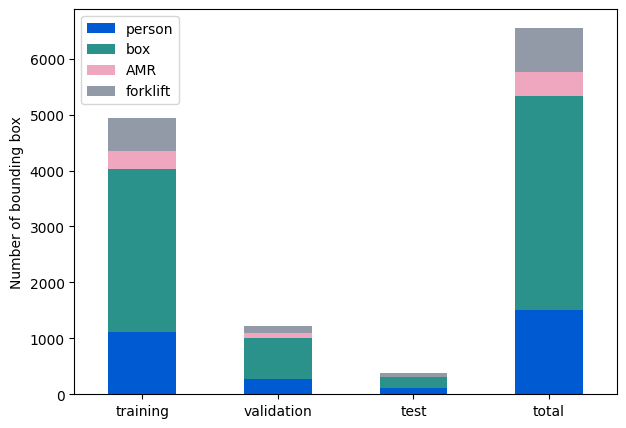

In [18]:
fig = repr_df.plot(y =["person", "box", "AMR", "forklift"], kind="bar", stacked=True, colormap="Paired", color=NOVO_COLORS[1:], ylabel="Number of bounding box", figsize=(7,5), rot=0)
fig.figure.savefig("reports/figures/class_occurence.png", dpi=300, bbox_inches="tight")

In [19]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

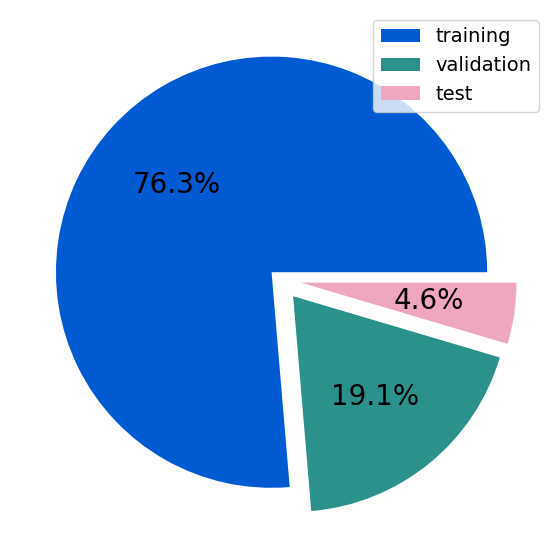

In [20]:
img_df = repr_df.loc[["training", "validation", "test"]].copy()
fig2 = img_df.plot.pie(y = "total", autopct = '%1.1f%%', colors=NOVO_COLORS[1:], labels = None, ylabel="", explode=[0.05, 0.1, 0.1], figsize = (7,7))
fig2.figure.savefig("reports/figures/data_splits.png", dpi=300, bbox_inches="tight")

# SSIM and before 

In [21]:
from src.data.filter_images import filterImages
from pathlib import Path
import pandas as pd
from src.data.manifests import cvat_to_dict


fi = filterImages(
    similarity_limit=0.7,
    input_root="/work3/s202821/data/interim/",
    output_root="/work3/s202821/data/dummy/",
    force=False,
    rgb_only=True,
    debug=True,
)

# bags_raw = fi._listbags_fullpath("/work3/s202821/data/raw")
bags_filt = fi._listbags_fullpath("/work3/s202821/data/interim")

# raw_sizes = {}

# for bag in bags_raw:
#     try:
#         bag_size = len(fi._list_images(bag))
#         raw_sizes[Path(bag).name] = bag_size
#     except:
#         pass

# raw = pd.DataFrame.from_dict(raw_sizes, orient="index", columns=["collected"], dtype="int")

raw = pd.read_csv("docs/raw.csv", sep=",", index_col=0, header=0)

filtered_sizes = {}
annotated_sizes = {}

for bag in bags_filt:



    try:
        with open(f"data/annotations/{Path(bag).name}.xml", "r", encoding="utf-8") as file:
            label_xml = file.read()

        annotation_dict = cvat_to_dict(
            xml_file=label_xml,
            collection=Path(bag).name,
            data_root="/work3/s202821/data/interim",
            create_mask=False
        )

        bag_size = len(fi._list_images(bag+"/synchronized_l515_image/"))
        filtered_sizes[Path(bag).name] = bag_size
        annotated_sizes[Path(bag).name] = len(annotation_dict)
    except:
        pass

filt = pd.DataFrame.from_dict(filtered_sizes, orient="index", columns=["filtered"], dtype="int")
ann = pd.DataFrame.from_dict(annotated_sizes, orient="index", columns=["annotated"], dtype="int")

df = pd.concat([raw, filt, ann], axis=1)
df.filtered = df.filtered.fillna(0).astype("int")
df.annotated = df.annotated.fillna(0).astype("int")
df["\% kept"] = round(df["filtered"] / df["collected"] * 100, 0).astype("int")
df["SSIM"] = 0.7
df


FileNotFoundError: [Errno 2] No such file or directory: 'docs/raw.csv'

In [ ]:
df["annotated"].sum()

2081

In [ ]:
styler = df.style
styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
styler.to_latex(
    buf="reports/figures/filtered_images.tex",
    caption="Number of images collected and filtered per collection run, where each name is the date-time combination indicating the start of the collection.",
    label="tab:filtered_images",
    position="htbp",
    position_float="centering",
    hrules=True,
    column_format="lrrrrr",
    convert_css=True,
    )